# 0. Galaxy image generation using VAEs.

In this notebook, we attempt to generate new galaxy images using Variational autoencoders.

Variation autoencoders (VAEs) are an extended type of autoencoders (AEs). A VAE can enhance the robustness of content generation by regularising the encodings distribution in the latent space. In this notebook, we will go through the fundamentals of VAEs (motivation, theory and Keras-based implementation) using a subset of the [Galaxy10 dataset](https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/). We use a slimmed down dataset which contains 5 classes:

'Disturbed', 'Merging', 'Round Smooth', 'Barred Spiral', 'Edge-on without Bulge'.

The aim of this work is to train a neural network to generate new galaxy images and learn their latent representations. 


In [1]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
from os.path import join

# need some certainty in data processing
np.random.seed(1234)
tf.random.set_seed(1234)

Using TensorFlow v2.7.0


## Google Cloud Storage Boilerplate

The following two cells have some boilerplate to mount the Google Cloud Storage bucket containing the data used for this notebook to your Google Colab file system. **Even you are not using Google Colab, please make sure you run these two cells.** 

To access the data from Google Colab, you need to:

1. Run the first cell;
2. Follow the link when prompted (you may be asked to log in with your Google account);
3. Copy the Google SDK token back into the prompt and press `Enter`;
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [2]:
# variables passed to bash; do not change
project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'
colab_data_path = '/content/sciml-workshop-data/'

try:
    from google.colab import auth
    auth.authenticate_user()
    google_colab_env = 'true'
    data_path = colab_data_path
except:
    google_colab_env = 'false'
    ###################################################
    ######## specify your local data path here ########
    ###################################################
    with open('../local_data_path.txt', 'r') as f: data_path = f.read().splitlines()[0]

In [3]:
%%bash -s {google_colab_env} {colab_data_path} {project_id} {bucket_name}

# running locally
if ! $1; then
    echo "Running notebook locally."
    exit
fi

# already mounted
if [ -d $2 ]; then
    echo "Data already mounted."
    exit
fi

# mount the bucket
echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
apt -qq update
apt -qq install gcsfuse
gcloud config set project $3
mkdir $2
gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 $4 $2

Running notebook locally.


---

# 1. Load the dataset

### Read raw data

The slimmed down dataset, which include the images with 8 labels, are stored in the h5 file `Astronomy/Galaxy5.h5`. We load this file using a `h5py` library.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# load dataset
with h5py.File(join(data_path, 'Astronomy/Galaxy5.h5'), 'r') as F:
    x = np.array(F['images'])
    y = np.array(F['ans'])
```
    
</p>
</details>

In [4]:
# load dataset
with h5py.File(join(data_path, 'Astronomy/Galaxy5.h5'), 'r') as F:
    x = np.array(F['images'])
    y = np.array(F['ans'])

In [5]:
# downsample the images - so that the model fits in memory.
x = x[:, ::2, ::2]

# normalise images    
x = x / 255.0

# split train test
train_images, test_images, train_labels, test_labels = train_test_split(x, y, test_size=0.2, random_state=0)


# string labels
string_labels = ['Disturbed', 'Merging', 'Round Smooth', 'Barred Spiral', 'Edge-on without Bulge']

# print info
print("Number of training data: %d" % len(train_labels))
print("Number of test data: %d" % len(test_labels))


Number of training data: 4000
Number of test data: 1000


### We can randomly plot some images and their labels

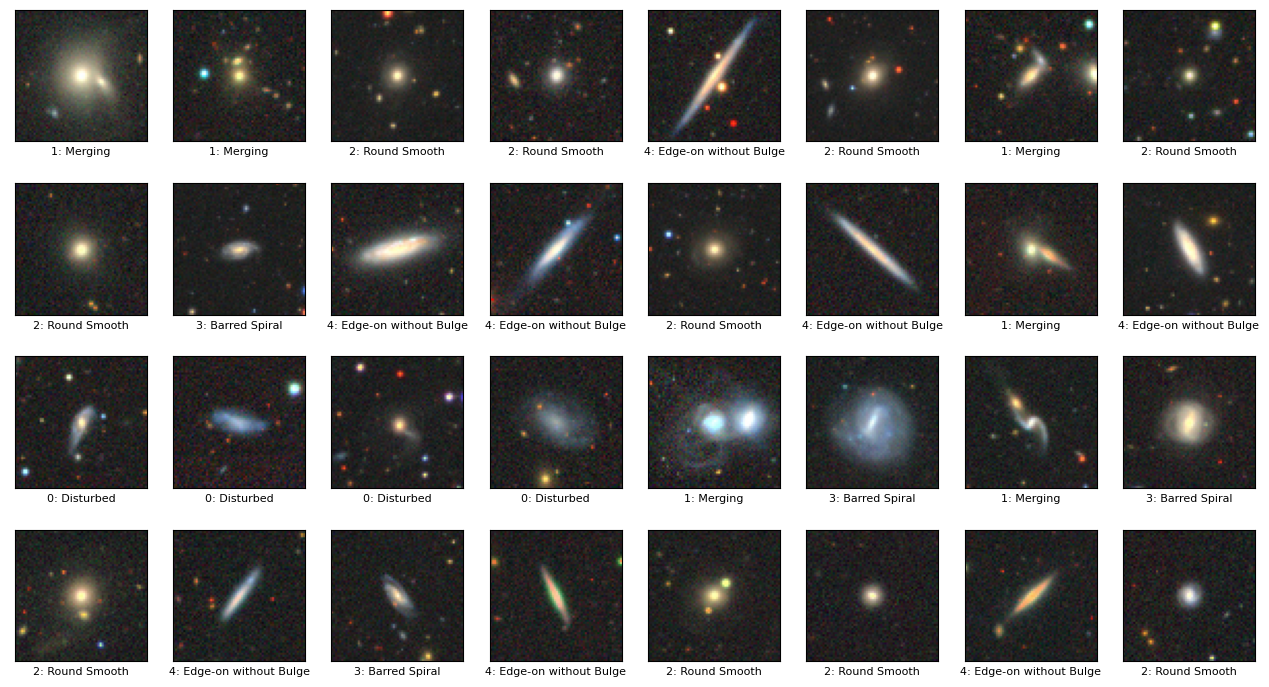

In [6]:
# function to plot an image in a subplot
def subplot_image(image, label, nrows=1, ncols=1, iplot=0, label2='', label2_color='r'):
    plt.subplot(nrows, ncols, iplot + 1)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(label, c='k', fontsize=8)
    plt.title(label2, c=label2_color, fontsize=8, y=-0.33)
    plt.xticks([])
    plt.yticks([])
    
# ramdomly plot some images and their labels
nrows = 4
ncols = 8
plt.figure(dpi=100, figsize=(ncols * 2, nrows * 2.2))
for iplot, idata in enumerate(np.random.choice(len(train_labels), nrows * ncols)):
    label = "%d: %s" % (train_labels[idata], string_labels[train_labels[idata]])
    subplot_image(train_images[idata].reshape(64, 64, 3), label, nrows, ncols, iplot)
plt.show()

---

# 2.Autoencoders and Regularity of Latent Space

Why we need a VAE? To answer this question, let us start with an ordinary AE and see what is unsatisfactory when we use it to generate new images. 

## Build and train an autoencoder

We can quickly build an AE with `Dense` layers. First, we specify the latent dimension or the size of the bottleneck; we use 2.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# latent dimension
latent_dim = 2
```
    
</p>
</details>

In [7]:
# latent dimension
latent_dim = 2

### The encoder

The encoder contains four layers, an input layer with size 128$\times$128, two hidden layers with sizes 2048, 512 and 128, respectively, and the latent output layer:

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# build the encoder
image_input = keras.Input(shape=(64, 64, 3))
x = layers.Conv2D(32, 4, 4, padding = 'same')(image_input)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(64, 4, 4, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
latent_output = layers.Dense(latent_dim)(x)
encoder_AE = keras.Model(image_input, latent_output)
encoder_AE.summary()
```
    
</p>
</details>

In [8]:
# build the encoder
image_input = keras.Input(shape=(64, 64, 3))
x = layers.Conv2D(32, 4, 4, padding = 'same')(image_input)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(64, 4, 4, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
latent_output = layers.Dense(latent_dim)(x)
encoder_AE = keras.Model(image_input, latent_output)
encoder_AE.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        1568      
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 16, 16, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 64)          32832     
                                                                 
 batch_normalization_1 (Batc  (None, 4, 4, 64)         256       
 hNormalization)                                             

2022-03-28 11:24:56.354135: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-28 11:24:56.902429: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14773 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3b:00.0, compute capability: 7.5


### The decoder

The decoder also contains four layers that are reciprocal to those of the encoders, taking the latent representation as the input:

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# build the decoder
latent_input = keras.Input(shape=(latent_dim,))
x = layers.Dense(64, activation="relu")(latent_input)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Reshape((4, 4, 64), input_shape=(1024,))(x)
x = layers.Conv2DTranspose(64, 4, 4, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2DTranspose(32, 4, 4, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
image_output = layers.Conv2D(3, 3, padding = 'same')(x)
#image_output = layers.Reshape((128, 128, 3))(x)
decoder_AE = keras.Model(latent_input, image_output)
decoder_AE.summary()
```
    
</p>
</details>

In [9]:
# build the decoder
latent_input = keras.Input(shape=(latent_dim,))
x = layers.Dense(64, activation="relu")(latent_input)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Reshape((4, 4, 64), input_shape=(1024,))(x)
x = layers.Conv2DTranspose(64, 4, 4, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2DTranspose(32, 4, 4, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
image_output = layers.Conv2D(3, 3, padding = 'same')(x)
#image_output = layers.Reshape((128, 128, 3))(x)
decoder_AE = keras.Model(latent_input, image_output)
decoder_AE.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 64)                192       
                                                                 
 dense_3 (Dense)             (None, 1024)              66560     
                                                                 
 reshape (Reshape)           (None, 4, 4, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 64)       65600     
 nspose)                                                         
                                                                 
 batch_normalization_2 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                           

### The autoencoder

Joining up the encoder and the decoder, we obtain the AE network:

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# build the AE
image_input = keras.Input(shape=(64, 64, 3))
latent = encoder_AE(image_input)
image_output = decoder_AE(latent)
ae_model = keras.Model(image_input, image_output)
ae_model.summary()

# compile the AE
ae_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
```
    
</p>
</details>

In [10]:
# build the AE
image_input = keras.Input(shape=(64, 64, 3))
latent = encoder_AE(image_input)
image_output = decoder_AE(latent)
ae_model = keras.Model(image_input, image_output)
ae_model.summary()

# compile the AE
ae_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 model (Functional)          (None, 2)                 100514    
                                                                 
 model_1 (Functional)        (None, 64, 64, 3)         166403    
                                                                 
Total params: 266,917
Trainable params: 266,533
Non-trainable params: 384
_________________________________________________________________


### Train the autoencoder

Now we can train our AE with the `Galaxy` dataset:

In [11]:
# train the AE
ae_model.fit(train_images, train_images, epochs=50, batch_size=128, 
             validation_data=(test_images, test_images))

Epoch 1/50


2022-03-28 11:24:59.085018: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-03-28 11:24:59.546255: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-28 11:24:59.546962: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-28 11:24:59.546976: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-03-28 11:24:59.547737: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-28 11:24:59.547783: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


32/32 [==============================] - 4s 42ms/step - loss: 0.0616 - mse: 0.0616 - val_loss: 0.0266 - val_mse: 0.0266
Epoch 2/50
32/32 [==============================] - 1s 25ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0221 - val_mse: 0.0221
Epoch 3/50
32/32 [==============================] - 1s 26ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0206 - val_mse: 0.0206
Epoch 4/50
32/32 [==============================] - 1s 26ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0200 - val_mse: 0.0200
Epoch 5/50
32/32 [==============================] - 1s 25ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0194 - val_mse: 0.0194
Epoch 6/50
32/32 [==============================] - 1s 25ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0189 - val_mse: 0.0189
Epoch 7/50
32/32 [==============================] - 1s 26ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0187 - val_mse: 0.0187
Epoch 8/50
32/32 [==============================] - 1s 25ms/step - loss: 0.0062 - mse: 0.0062 

---

# 3. Analyse results 

Let us inspect how the images are distributed in the latent space. 

### Encode images

First, we encode the images by our AE. After that, each image becomes a 2D point (because `latent_dim=2`) in the latent space. 

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# encode images by AE
train_encodings_AE = encoder_AE.predict(train_images)
```
    
</p>
</details>

In [12]:
# encode images by AE
train_encodings_AE = encoder_AE.predict(train_images)

### Scatter plot
We can plot the points in the latent space and colour them by their true labels:

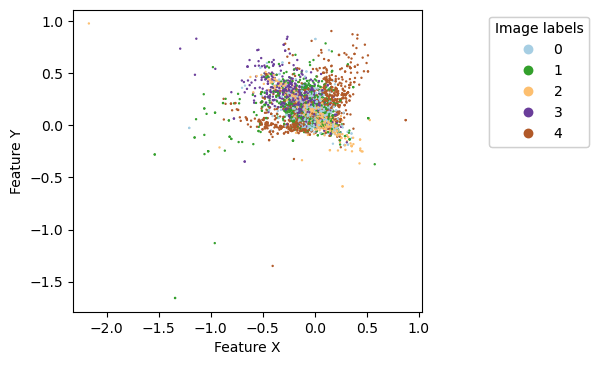

In [13]:
# scatter plot of encodings in the latent space
def scatter_plot_encodings_latent(encodings, labels):
    plt.figure(dpi=100)
    scat = plt.scatter(encodings[:, 0], encodings[:, 1], c=labels, s=.5, cmap='Paired')
    plt.gca().add_artist(plt.legend(*scat.legend_elements(), 
                         title='Image labels', bbox_to_anchor=(1.5, 1.)))
    plt.xlabel('Feature X')
    plt.ylabel('Feature Y')
    plt.gca().set_aspect(1)
    plt.show()
    
# scatter plot of encodings by AE
scatter_plot_encodings_latent(train_encodings_AE, train_labels)

###  Histogram plot

Also, for each galaxy type, we can plot the density histograms of the encodings along the two latent dimensions -- note that we are using the same feature range ($x$-axis) in all the histograms:

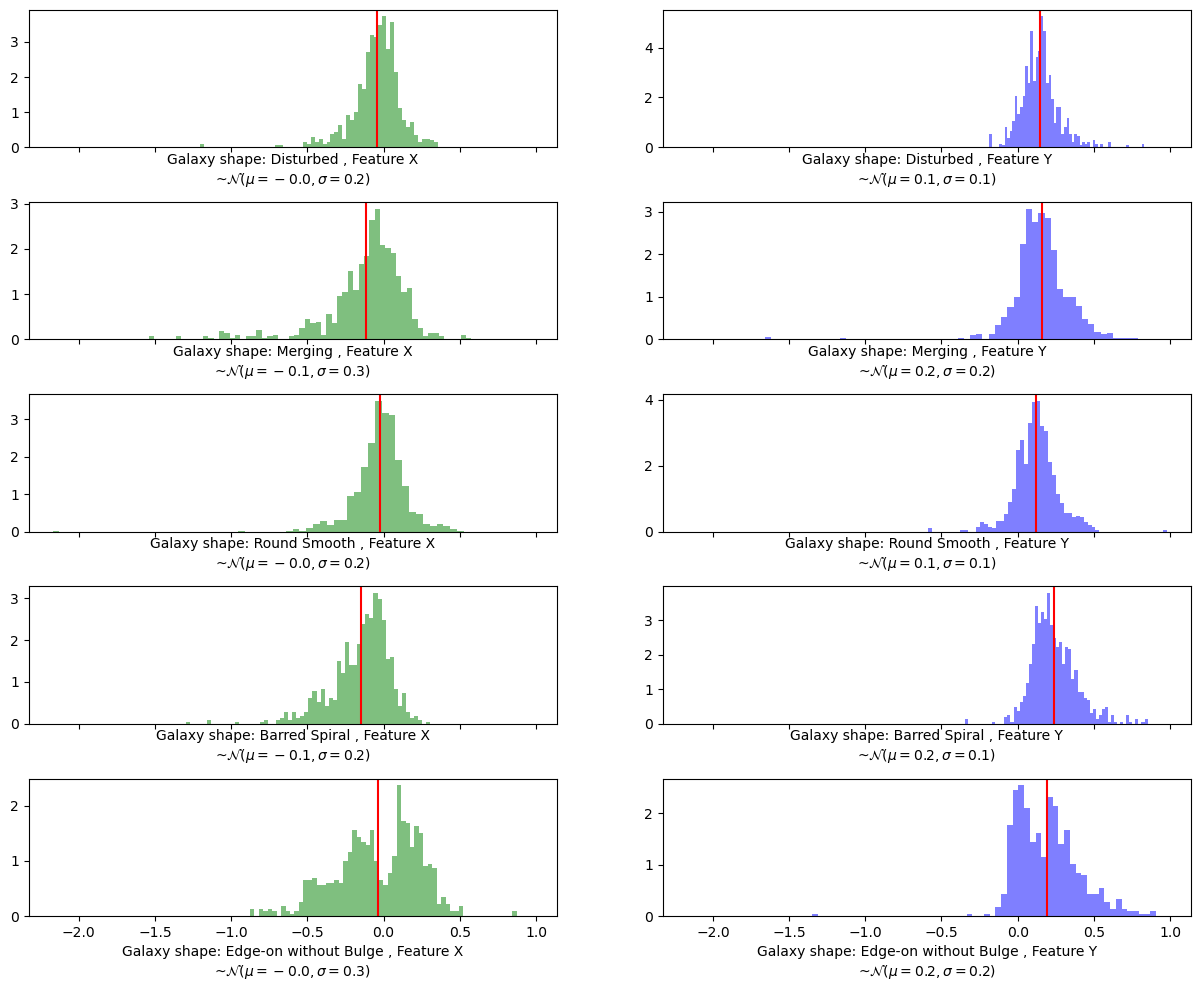

In [14]:
# histogram plot of encodings in the latent space
def hist_plot_encodings_latent(encodings, labels, galaxy_id, dim, ax):
    # extract
    encodings_ = encodings[labels == galaxy_id, dim]
    # histogram
    ax.hist(encodings_, bins=60, density=True, color=['g', 'b'][dim], alpha=.5)
    # mean and std dev
    mean = np.mean(encodings_)
    std = np.std(encodings_)
    ax.axvline(mean, c='r')
    ax.set_xlabel('Galaxy shape: %s , Feature %s\n~${\cal N}(\mu=%.1f, \sigma=%.1f)$' % 
                  (string_labels[galaxy_id], ['X', 'Y'][dim], mean, std), c='k')
    
# histogram plot of encodings by AE
fig, axes = plt.subplots(5, 2, dpi=100, figsize=(15, 12), sharex=True)
plt.subplots_adjust(hspace=.4)
for galaxy_id in range(5):
    hist_plot_encodings_latent(train_encodings_AE, train_labels, galaxy_id, 0, 
                               axes[galaxy_id,  0])
    hist_plot_encodings_latent(train_encodings_AE, train_labels, galaxy_id, 1, 
                               axes[galaxy_id, 1])
plt.show()

### Regularity of the latent space

Both the scatter plot and the histogram plots show that the data distributions in the latent space are rather *irregular*. Some of the digits have very wide distributions (such as Barred Spiral).

Remember that our goal of training this AE is neither dimensionality reduction nor denoising but to generate new images out of the original dataset. Image generation is done by the decoder, taking the latent representation (`X` and `Y` in the plots) as the input. An irregular latent space makes image generation less controllable and robust. Taking our case for example, two shortcomings are likely to emerge:

1. **Controllability**: sampling the entire latent space, we will generate much more of the widely distributed digits than the narrowly distributed ones; instead, if we limit the range of the latent space, we will loss some characteristics of the widely distributed ones;

2. **Robustness**: images that do not resemble any of the digits will be generated by the gaps between the distributions of the digits; such gaps increase with the range of the latent space.

### Generate new images

The following function generates new images by uniformly sampling the latent space within a specified range (`[x0, x1]`, `[y0, y1]`). 

In [15]:
# generate images from the latent space
def generate_images_latent(decoder, x0, x1, dx, y0, y1, dy):
    # uniformly sample the latent space
    nx = 10
    ny = 10
    grid_x = np.linspace(x0, x1, nx)
    grid_y = np.linspace(y1, y0, ny)
    latent = np.array(np.meshgrid(grid_x, grid_y)).reshape(2, nx * ny).T

    # decode images
    decodings = decoder.predict(latent)
    
    # display a (nx, ny) 2D manifold of digits
    figure = np.zeros((64 * ny, 64 * nx, 3))
    for iy in np.arange(ny):
        for ix in np.arange(nx):
            figure[iy * 64 : (iy + 1) * 64, ix * 64 : (ix + 1) * 64, :] = decodings[iy * nx + ix].reshape(64, 64, 3)
            
    # plot figure
    plt.figure(dpi=100, figsize=(nx / 3, ny / 3))
    plt.xticks(np.arange(64 // 2, nx * 64 + 64 // 2, 64), np.round(grid_x, 1), rotation=90)
    plt.yticks(np.arange(64 // 2, ny * 64 + 64 // 2, 64), np.round(grid_y, 1))
    plt.xlabel('Feature X')
    plt.ylabel('Feature Y')
    plt.imshow(figure)
    plt.grid(False)
    plt.show()

Let us see how the generated images look like. We choose 1-th percentile and 99-th percentile of each axis as minimum and maximum values in the latent space, which encompass all the galaxy shapes and most of the data points. The shortcoming can be observed:

Only a very few instances of the narrowly distributed galaxies are generated;

Feel free to try some other ranges. 

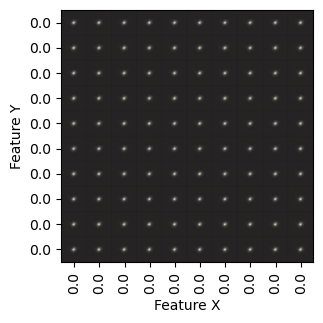

In [16]:
# generate images by AE
x_min = int(np.percentile(train_encodings_AE[:, 0], 1))
x_max = int(np.percentile(train_encodings_AE[:, 0], 99))
y_min = int(np.percentile(train_encodings_AE[:, 1], 1))
y_max = int(np.percentile(train_encodings_AE[:, 1], 99))

generate_images_latent(decoder_AE, x0=x_min, x1=x_max, dx=1, y0=y_min, y1=y_max, dy=1)

---

# 4. Variational Autoencoders

Overfitting is the essential reason behind an irregular latent space of a naive AE, that is, the neural networks for encoding and decoding try their best to fit the data from end to end without caring about how the latent space is organised with respect to the original data. A VAE can regularise the latent space by imposing additional distributional properties on the latent space.

The following figure summarises **the two extensions** from an AE to a VAE:

1. Unlike a naive AE that encodes an input data $x$ as a single point $z$ in the latent space, a VAE encodes it as a normal distribution $\mathcal{N}(\mu, \sigma)$, and the latent representation $z$ is sampled from this distribution and then passed to the decoder;

2. An AE only minimises the reconstruction error $\lVert x-x'\rVert^2$ to fit the data, whereas a VAE minimises the sum of the reconstruction error and the KL divergence (Kullback–Leibler divergence) between the latent distribution $\mathcal{N}(\mu, \sigma)$ and the standard normal distribution $\mathcal{N}(0, 1)$.

How does a VAE regularise the latent space? The loss function provides a straightforward answer: in addition to fitting the data by minimising the reconstruction error, it also drags the latent distribution to a standard normal distribution. The final model is a trade-off between the two effects. Also, because each input image is encoded as a Gaussian blob instead of a single point, the gaps in the latent space can be filled by such blurring so that meaningless decodings can be largely avoided.

![ae-vae.png](https://github.com/stfc-sciml/sciml-workshop-v3/blob/master/course_3.0_with_solutions/markdown_pic/ae-vae.png?raw=1)


**📚 Theory for VAEs** 

<details> <summary>Reveal / Hide</summary> 
<p>
    



### Derivation of ELBO

Posterior Probability $p(z|x)$, which can be expressed as:

\begin{eqnarray}
p(z|x)&=&\frac{p(x|z)p(z)}{p(x)}\nonumber\\
&=& \frac{p(x|z)p(z)}{\int p(x|z)p(z)}
\end{eqnarray}

where $\int p(x|z)p(z)$, which is the marginal, can be intractable and cannot be computed directly. One way  to compute the overall solution $p(z|x)$ is using Monte Carlo methods (such as sampling). The method used in this notebook (and the underlying VAE paper) is  ***variational inference***. 

The idea is to identify another proxy distribution $q(z|x)$ that reasonably approximates $p(z|x)=p(x|z)p(z)$. i.e. if the KL-divergence between two pdfs, $q(x)$ and $p(z|x)$ is denoted by

$$\mathrm{KL}(q(x)||p(z|x))$$


it can be minimized by selecting an alternative pdf $q(z|x)$, which is a good proxy for $p(z|x)$. But 

\begin{eqnarray}
\mathrm{KL}(q(z|x)||p(z|x)) &=& -\int q(z|x)\log\frac{p(z|x)}{q(z|x)} dz\nonumber\\
                          &=& -\int q(z|x)\log\frac{p(x|z)p(z)}{p(x)q(z|x)} dz\nonumber\\
                          &=& -\int q(z|x)\log\frac{p(x|z)p(z)}{q(z|x)}dz + \int_{z} q(z|x)\log p(x)dz \nonumber\\
                          &=& -\int q(z|x)\log\frac{p(x|z)p(z)}{q(z|x)} +  \log p(x)\int_{z} q(z|x)dz\nonumber\\   
                          &=& -\int q(z|x)\log\frac{p(x|z)p(z)}{q(z|x)}dz +  \log p(x)\nonumber\\
                          &=& -\int q(z|x)\log\frac{p(z)}{q(z|x)}dz -\int q(z|x)\log{p(x|z)}dz + \log p(x) 
\end{eqnarray}


Given that $\mathrm{KL}\left(q(z|x)||p(z|x)\right)\geq 0$, 




\begin{eqnarray}
-\int q(z|x)\log\frac{p(z)}{q(z|x)}dz -\int q(z|x)\log{p(x|z)}dz + \log p(x) &\geq& 0 \\
\log p(x) &\geq& \int q(z|x)\log\frac{p(z)}{q(z|x)}dz + \int q(z|x)\log{p(x|z)}dz\\
\log p(x) &\geq& - \mathrm{KL}(q(z|x)||p(z)) + \int q(z|x)\log p(x|z)dz \nonumber\\
\log p(x) &\geq& - \mathrm{KL}(q(z|x)||p(z)) + \mathbb{E}_{q(z|x)}\left[\log p(x|z)\right] \nonumber\\
\end{eqnarray}

This is the *variational lower-bound*, or the evidence of lower bound (ELBO).  This remains as the objective function for the VAE. However, frameworks like TensorFlow or PyTorch need a loss function to be minimized. Maximising the log likelihood of the model evidence $p(x)$ is same as minimizing the $-\log p(x)$. The first term of the ELBO, namely,  $\mathrm{KL}(q(z|x)||p(z))$ is the *regularising* term and constrains the posterior distribution. The second term of the ELBO models the reconstruction loss. 

Now, this leaves fair bit of freedom on the choice of the prior $p(z)$. Let's assume:


$$
p(z)={\cal N}(\mu_p, \sigma_p^2)
$$

and 

$$
q(z|x)={\cal N}(\mu_q, \sigma_q^2)
$$

Thus, 

$$
p(z)=\frac{1}{\sqrt{2\pi\sigma_p^2}}\exp\left(\frac{(x-\mu_p)^2}{2\sigma_p^2}\right)
$$

and 

$$
q(z|x)=\frac{1}{\sqrt{2\pi\sigma_q^2}}\exp\left(\frac{(x-\mu_q)^2}{2\sigma_q^2}\right)
$$

The direct derivation of $\mathrm{KL}(q(z|x)||p(z))$ will give (with some simplifications)


$$
-\mathrm{KL}(q(z|x)||p(z)) = \log\frac{\sigma_q}{\sigma_p} - \frac{\left(\log\sigma_q^2-(\mu_p-\mu_q)^2\right)}{2\sigma_p^2} +\frac{1}{2} 
$$

By fixing the prior distribution $p(z)={\cal N}(0,1^2)$, 

$$
-\mathrm{KL}(q(z|x)||p(z)) = \frac{1}{2}\left[ 1 + \log\sigma_q^2 - \sigma_q^2 -\mu_q^2\right]
$$

Hence, the new ELBO is


$$
\frac{1}{2}\left[ 1 + \log\sigma_q^2 - \sigma_q^2 -\mu_q^2\right] + \mathbb{E}_{q(z|x)}\left[\log p(x|z)\right] 
$$


Let $J, B$ and $\cal{L}$ be the dimension of the latent space, and the batch size over which the sampling is done. The loss function we need to minimise (from the point of  implementation) is

$$
{\cal L} = - \sum_{j=1}^J \frac{1}{2}\Bigl[ 1 + \log\sigma_j^2 - \sigma_j^2 -\mu_j^2\Bigr] - \frac{1}{B}\sum_{l}\mathbb{E}_{q(z|x_i)}\left[\log p(x_i|z^{(i,l)})\right] 
$$



This can be observed in the code implementation below (see function implementation ``loss_function`` below)

### Reparameterisation

A valid reparameterization would be 

$$
z = \mu+\sigma\epsilon
$$


where $\epsilon$ is an auxiliary noise variable $\epsilon\sim{\cal{N}}(0, 1)$, which actually enables the reparameterization technique. Although it is possible to use $\sigma$ or more specifically $\sigma^2$, working on log scales improves the stability. i.e. 

\begin{eqnarray}
p &=& \log(\sigma^2)\\
&=& 2  \log(\sigma)
\end{eqnarray}

To get the log standard deviation, $\log(\sigma)$, 
\begin{eqnarray}
\log(\sigma) &=&  p/2 \\
\label{eqn:log_sigma}
\end{eqnarray} 

and hence

$$
\sigma = \exp^{p/2}
$$

The resulting estimator (or the loss function) becomes (see Page 5 of [Auto-Encoding Variational Bayes Paper](https://arxiv.org/abs/1312.6114)),

$$
-\text{KLD} = \frac{1}{2}\sum_{j=1}^{J}(1+\log(\sigma_j^i)^2 - (\mu_j^i)^2 -(\sigma_j^i)^2)
$$


It is important to see that the KL divergence can be computed and differentiated without estimation. This is a very remarkable thing (no esimtation!).

The $\boldsymbol{\epsilon}$ must be sampled from a zero-mean, unit-variance Gaussian distribution, and should be of the same size as $\boldsymbol{\sigma}$. 


<br>


    
</p>
</details>

## Build and train a VAE

Now we will implement a VAE. 


### The encoder

To implement the probabilistic encoder, we first need a custom function to sample the latent distribution, as implemented by the `Sampling` class. Note that here we are using $\ln\sigma$ instead of $\sigma$ in the network; otherwise, the implementation will be complicated as we have to impose positiveness on $\sigma$.  

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# sampling z with (z_mean, z_log_var)
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon




# build the encoder
image_input = keras.Input(shape=(64, 64, 3))
x = layers.Conv2D(32, 4, 2, padding = 'same')(image_input)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(32, 4, 2, padding = 'same')(image_input)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(64, 4, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(64, 4, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z_output = Sampling()([z_mean, z_log_var])
encoder_VAE = keras.Model(image_input, [z_mean, z_log_var, z_output])
encoder_VAE.summary()
```
    
</p>
</details>

In [17]:
# sampling z with (z_mean, z_log_var)
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon




# build the encoder
image_input = keras.Input(shape=(64, 64, 3))
x = layers.Conv2D(32, 4, 2, padding = 'same')(image_input)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(32, 4, 2, padding = 'same')(image_input)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(64, 4, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(64, 4, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z_output = Sampling()([z_mean, z_log_var])
encoder_VAE = keras.Model(image_input, [z_mean, z_log_var, z_output])
encoder_VAE.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 32, 32, 32)   1568        ['input_4[0][0]']                
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 32, 32, 32)  128         ['conv2d_4[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_5 (Activation)      (None, 32, 32, 32)   0           ['batch_normalization_5[0][

### The decoder

The docoder is the same as that of AE.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# build the decoder
latent_input = keras.Input(shape=(latent_dim,))
x = layers.Dense(64, activation="relu")(latent_input)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Reshape((4, 4, 64), input_shape=(1024,))(x)
x = layers.Conv2DTranspose(64, 4, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2DTranspose(64, 4, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2DTranspose(32, 4, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2DTranspose(32, 4, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
image_output = layers.Conv2D(3, 3, activation = 'sigmoid', padding = 'same')(x)
decoder_VAE = keras.Model(latent_input, image_output)
decoder_VAE.summary()
```
    
</p>
</details>

In [18]:
# build the decoder
latent_input = keras.Input(shape=(latent_dim,))
x = layers.Dense(64, activation="relu")(latent_input)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Reshape((4, 4, 64), input_shape=(1024,))(x)
x = layers.Conv2DTranspose(64, 4, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2DTranspose(64, 4, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2DTranspose(32, 4, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2DTranspose(32, 4, 2, padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
image_output = layers.Conv2D(3, 3, activation = 'sigmoid', padding = 'same')(x)
decoder_VAE = keras.Model(latent_input, image_output)
decoder_VAE.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_5 (Dense)             (None, 64)                192       
                                                                 
 dense_6 (Dense)             (None, 1024)              66560     
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 64)          0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 8, 8, 64)         65600     
 ranspose)                                                       
                                                                 
 batch_normalization_8 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                           

### The VAE

To add the KL divergence to the loss, we create a class `VAE` derived from `keras.Model` and overwrite its `train_step()` method:

In [19]:
# VAE class
class VAE(keras.Model):
    # constructor
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    # customise train_step() to implement the loss 
    def train_step(self, x):
        if isinstance(x, tuple):
            x = x[0]
        with tf.GradientTape() as tape:
            # encoding
            z_mean, z_log_var, z = self.encoder(x)
            # decoding
            x_prime = self.decoder(z)
            # reconstruction error by binary crossentropy loss
            #reconstruction_loss = tf.reduce_mean(keras.losses.mean_squared_error(x, x_prime))
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(x, x_prime), axis=(1, 2)
                )
            )
            # KL divergence
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            # loss = reconstruction error + KL divergence
            loss = reconstruction_loss + kl_loss
        # apply gradient
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # return loss for metrics log
        return {"loss": loss,
                "reconstruction_loss": reconstruction_loss,
                "kl_loss": kl_loss}

Now we can build, compile and train our VAE:

In [20]:
# build the VAE
vae_model = VAE(encoder_VAE, decoder_VAE)

# compile the VAE
vae_model.compile(optimizer=keras.optimizers.Adam())

# train the VAE
vae_model.fit(train_images, train_images, epochs=50, batch_size=128)

Epoch 1/50
32/32 [==============================] - 2s 32ms/step - loss: 239.1294 - reconstruction_loss: 233.9864 - kl_loss: 5.1430
Epoch 2/50
32/32 [==============================] - 1s 28ms/step - loss: 55.1583 - reconstruction_loss: 55.1551 - kl_loss: 0.0033
Epoch 3/50
32/32 [==============================] - 1s 28ms/step - loss: 41.1253 - reconstruction_loss: 40.8926 - kl_loss: 0.2327
Epoch 4/50
32/32 [==============================] - 1s 28ms/step - loss: 36.5647 - reconstruction_loss: 36.2845 - kl_loss: 0.2802
Epoch 5/50
32/32 [==============================] - 1s 28ms/step - loss: 34.8703 - reconstruction_loss: 34.6584 - kl_loss: 0.2118
Epoch 6/50
32/32 [==============================] - 1s 28ms/step - loss: 33.6207 - reconstruction_loss: 33.4363 - kl_loss: 0.1844
Epoch 7/50
32/32 [==============================] - 1s 28ms/step - loss: 31.5236 - reconstruction_loss: 31.2534 - kl_loss: 0.2702
Epoch 8/50
32/32 [==============================] - 1s 28ms/step - loss: 30.4993 - recon

---

# 5. Analyse results 
Next, we can inspect the latent space following the same steps we did for the AE. Clearly, the latent distributions become much more regular than before.

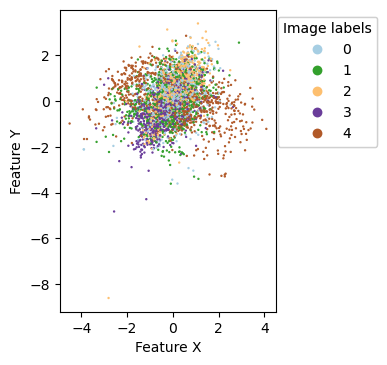

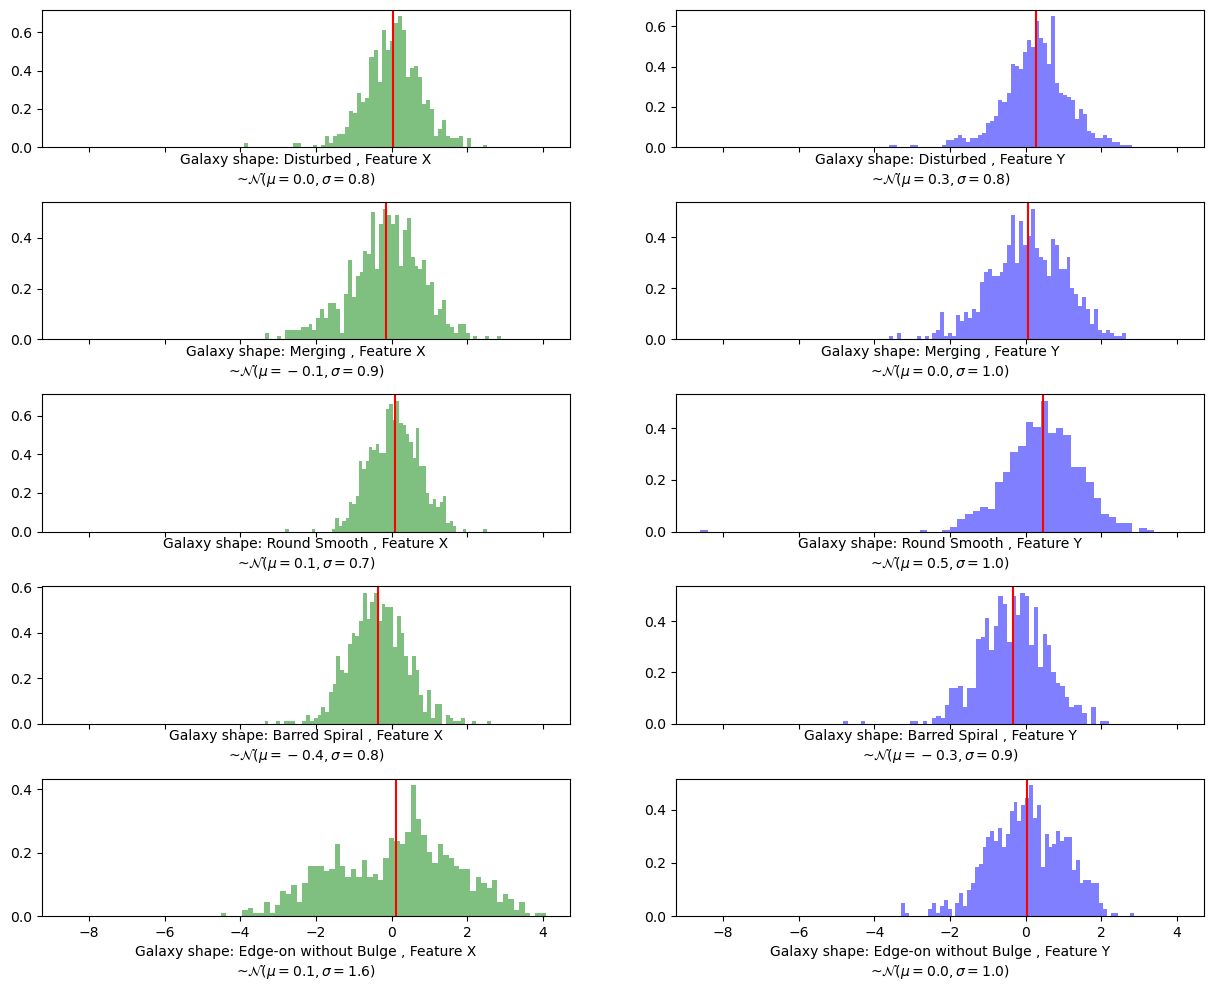

In [21]:
# encode images by VAE
train_encodings_VAE = encoder_VAE.predict(train_images)

# scatter plot of encodings by VAE
scatter_plot_encodings_latent(train_encodings_VAE[2], train_labels)

# histogram plot of encodings by VAE
fig, axes = plt.subplots(5, 2, dpi=100, figsize=(15, 12), sharex=True)
plt.subplots_adjust(hspace=.4)
for galaxy_id in range(5):
    hist_plot_encodings_latent(train_encodings_VAE[2], train_labels, galaxy_id, 0, 
                               axes[galaxy_id, 0])
    hist_plot_encodings_latent(train_encodings_VAE[2], train_labels, galaxy_id, 1, 
                               axes[galaxy_id, 1])
plt.show()

### Generate new images

Finally, we can generate new images with our VAE. The result shows that, compared to the AE, the numbers of the generated digits have become more in unison and the number of non-digit images has been greatly reduced.

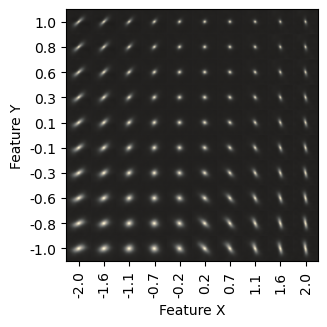

In [22]:
# generate images by AE
x_min = int(np.percentile(train_encodings_VAE[2][:, 0], 2))
x_max = int(np.percentile(train_encodings_VAE[2][:, 0], 98))
y_min = int(np.percentile(train_encodings_VAE[2][:, 1], 2))
y_max = int(np.percentile(train_encodings_VAE[2][:, 1], 98))


generate_images_latent(decoder_VAE, x0=x_min, x1=x_max, dx=.1, y0=y_min, y1=y_max, dy=.1)

---

# 6.Exercises


* Learn advanced VAEs:

    * **disentangled VAEs**: how to balance between reconstruction loss (image quality) and variational loss (latent regularity);
    
    * **conditional VAEs**: how to control image generation, e.g., generating an image of a handwritten digit given that digit from 0 to 9.